In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn import linear_model

df=pd.read_excel("Complete-dataset-FINAL.xlsx")

### Note
Dit model is een alternatief voor de lineare regressie model. De algemene bunsiness & data understanding zijn te vinden in de Jupyter notebook van de lineare regressie. In deze notebook zal er gefocust worden op het voorspellingsmodel (ARIMA model).

# Business understanding
We gaan het ARIMA model gebruiken. Hier gaan we kijken of de data stationair is, wat betekent dat een tijdsreeks niet afhankelijk is van tijd. Eerst zullen de parameters voor het ARIMA model worden bepaald. ARIMA(p=?, d=?,q=?)

### ARIMA modellen
Het doel van een ARIMA model is het nabootsen van een tijdsserie. Dit wordt gedaan door de variaties in de data te modelleren door middel van de volgende drie opties: 

- AR (auto-regressief), voorgaande waardes worden gebruikt om nieuwe waardes te voorspellen.
- I (integrated), niet de originele serie maar een gedifferentieerde tijdsserie wordt gebruikt. Dit om de tijdsserie stationair te maken. 
- MA (moving average), voorafgaande fouten worden gebruikt om nieuwe fouten voorspellen. Dit heeft een smoothing effect, een bewegend gemiddelde. 

Door deze effecten te mengen kun je de meeste tijdsseries nabootsen. In de volgende sectie gaan we de effecten van de AR en MA termen op een tijdsserie bekijken. 



# Data preparation

In [38]:
df=df.dropna()

In [39]:
manufacturers = df.groupby("Manufacturer")
manufacturers.size().nlargest(20)

Manufacturer
Siemens                      918
Bio-Rad                      667
Roche Diagnostics            605
Beckman Coulter              349
Tosoh                        284
Abbott                       278
Sebia                        201
Trinity Biotech              185
Vitros                       139
Alere                        111
Arkray                        78
Axis-Shield                   57
Menarini                      52
Synchron                      21
Not specified                 20
Roche Diagnostics/Hitachi     18
Bayer/Metrika                 15
Bayer                          6
HemoCue                        6
JEOL                           6
dtype: int64

In [40]:
df.columns = df.columns.str.replace('Total Error', 'Total')
df.columns

Index(['Method name', 'N (no. labs)', 'Mean', 'Bias', 'CV', 'Sample',
       'Reference Value', 'Year', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)',
       'Manufacturer', 'Total'],
      dtype='object')

In [41]:
list_top10 = df['Manufacturer'].value_counts()[:10].index.tolist()
top10_manufacturers = df.loc[df['Manufacturer'].isin(list_top10)]
top10_manufacturers['Manufacturer'].value_counts()


Siemens              918
Bio-Rad              667
Roche Diagnostics    605
Beckman Coulter      349
Tosoh                284
Abbott               278
Sebia                201
Trinity Biotech      185
Vitros               139
Alere                111
Name: Manufacturer, dtype: int64

In [42]:
top10_manufacturers = top10_manufacturers.dropna()
top10_manufacturers=top10_manufacturers[['Manufacturer', 'Total', 'Year']]
top10_manufacturers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3737 entries, 0 to 4683
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Manufacturer  3737 non-null   object 
 1   Total         3737 non-null   float64
 2   Year          3737 non-null   float64
dtypes: float64(2), object(1)
memory usage: 116.8+ KB


<AxesSubplot:xlabel='Year', ylabel='Total'>

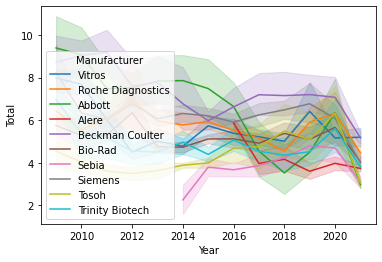

In [43]:
sns.lineplot(x="Year", y="Total",
             hue="Manufacturer", 
             data=top10_manufacturers)

# Modeling

#model regressie trainen en testen
#R2 zegt iets over de bruikbaarheid van je model
traindata, testdata = train_test_split(Siemens, train_size=0.65, test_size=0.35, random_state=42)

#eerst afhankelijke variabele, dus hierbij 'Manufacturer'
mod1 = ols(formula='Year ~ Total', data=traindata).fit()
print(mod1.summary())

In [44]:
# traindata, testdata = train_test_split(df, train_size=0.65, test_size=0.35, random_state=42)

# X_train, X_test, Y_train, Y_test = train_test_split(df["Year"].values, df["Manufacturer"].values, test_size = .20, random_state = 40)
top10_manufacturers= top10_manufacturers.dropna()


In [58]:
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series data can said to have stationarity
from statsmodels.tsa.stattools import adfuller
manufacturers = top10_manufacturers.groupby("Manufacturer")
#differentiate with last value -? first value is always nan
#AIC input is to compute the optimal number iteratively.
for name, data in manufacturers: 
    data= data.dropna()
    print(name) 
    df_stationarityTest = adfuller(data['Total'].diff().dropna(), autolag='AIC')    
    print("P-value: one ", df_stationarityTest[1])

    df_stationarityTest = adfuller(data['Total'].diff().diff().dropna(), autolag='AIC')    
    print("P-value: two ", df_stationarityTest[1])

    df_stationarityTest = adfuller(data['Total'].diff().diff().diff().dropna(), autolag='AIC')    
    print("P-value: three ", df_stationarityTest[1])

    df_stationarityTest = adfuller(data['Total'].diff().diff().diff().diff().dropna(), autolag='AIC')    
    print("P-value: four", df_stationarityTest[1])
    print("\n")
    print(f'ADF Statistic: {df_stationarityTest[0]}')
    print(f'n_lags: {df_stationarityTest[1]}')
    print(f'p-value: {df_stationarityTest[1]}')
    for key, value in df_stationarityTest[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')    

    print("\n")

Abbott
P-value: one  2.4157069378753383e-06
P-value: two  2.319181934104945e-12
P-value: three  5.358352824502742e-16
P-value: four 2.044762470676813e-21


ADF Statistic: -11.650319247377873
n_lags: 2.044762470676813e-21
p-value: 2.044762470676813e-21
Critial Values:
   1%, -3.4560535712549925
Critial Values:
   5%, -2.8728527662442334
Critial Values:
   10%, -2.5727985212493754


Alere
P-value: one  1.0681195031019741e-09
P-value: two  9.494019059345426e-08
P-value: three  5.854000226969052e-11
P-value: four 2.2949068678014735e-10


ADF Statistic: -7.206347141565556
n_lags: 2.2949068678014735e-10
p-value: 2.2949068678014735e-10
Critial Values:
   1%, -3.502704609582561
Critial Values:
   5%, -2.8931578098779522
Critial Values:
   10%, -2.583636712914788


Beckman Coulter
P-value: one  1.1298129981266867e-25
P-value: two  7.498452021204894e-20
P-value: three  9.827638078544958e-17
P-value: four 1.5414449651620286e-21


ADF Statistic: -11.704373774750739
n_lags: 1.5414449651620286e-21
p

### Analyse van p-values
Een p-value van 0.05 of er onder ligt, betekent dat de data stationair is. De resultaten laten zien dat de data niet stationair is. De voorspelling van de tijdsreeks niet volledig afhankkelijk zijn. Dit betekent dat de resultaten een ongeschikte voorspelling creëren.

Abbott


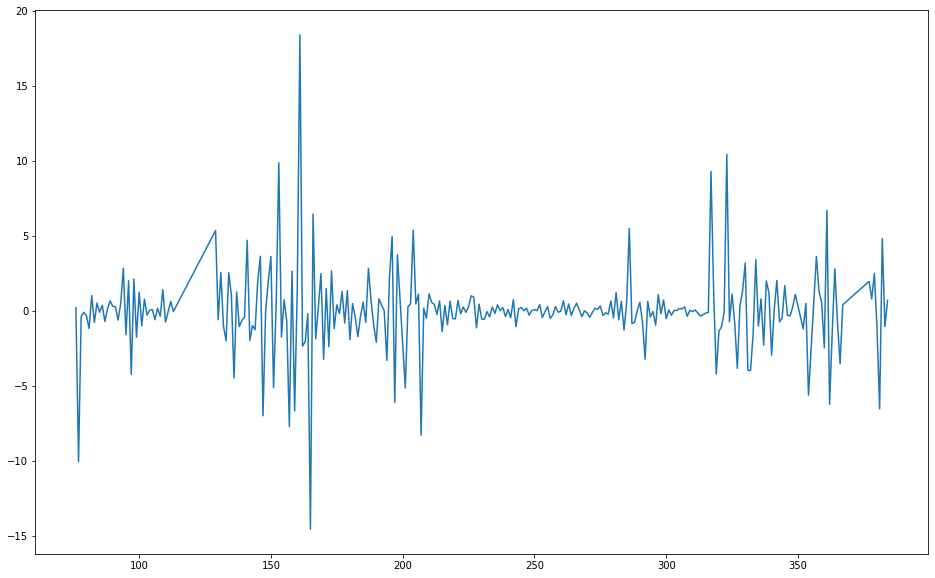

Alere


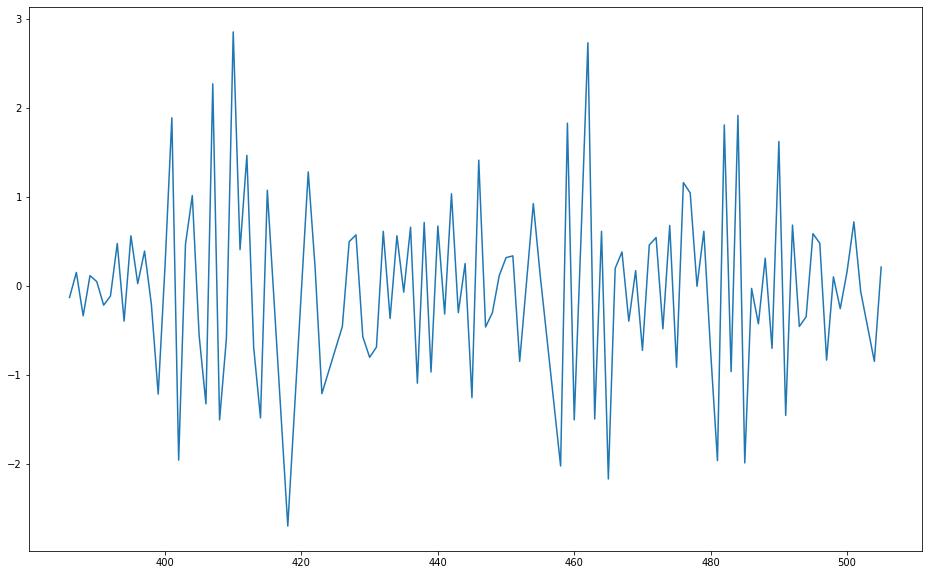

Beckman Coulter


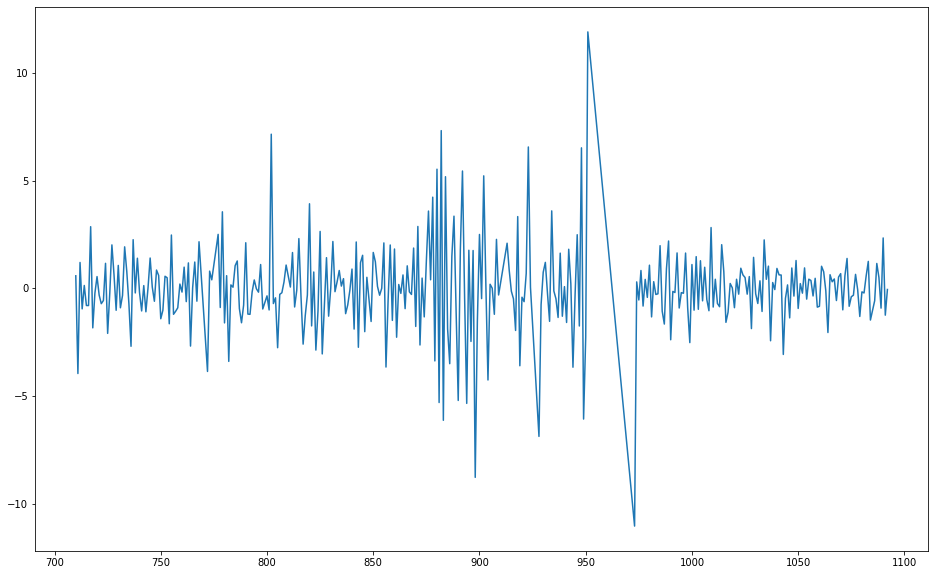

Bio-Rad


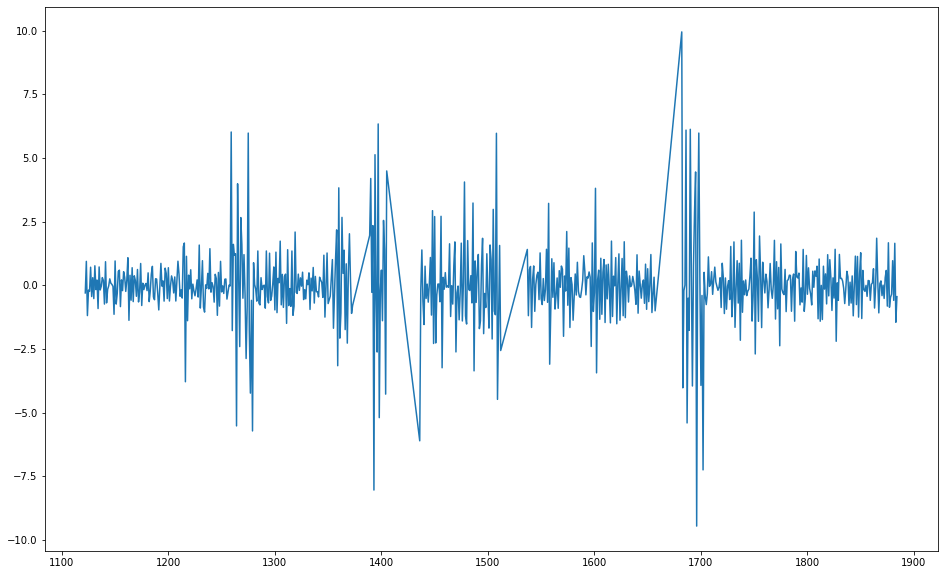

Roche Diagnostics


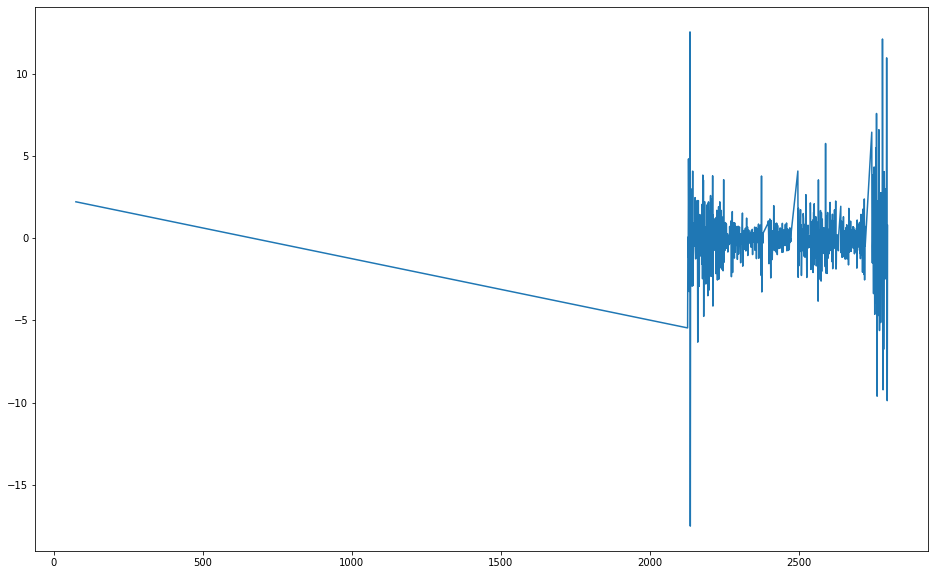

Sebia


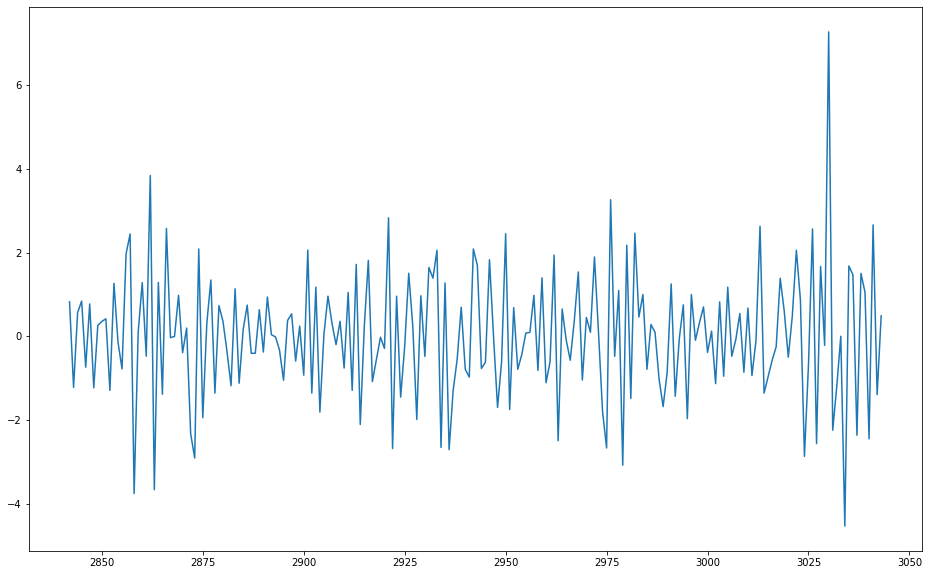

Siemens


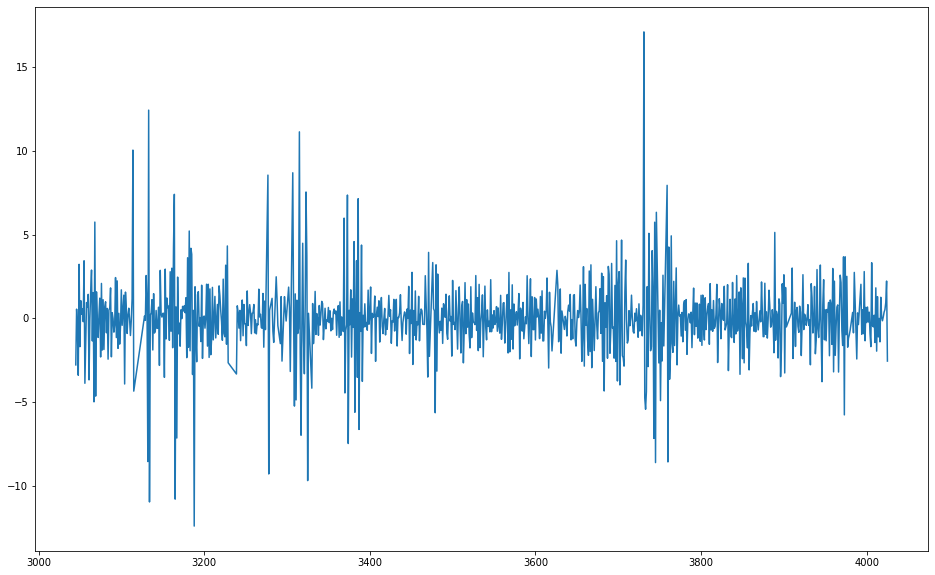

Tosoh


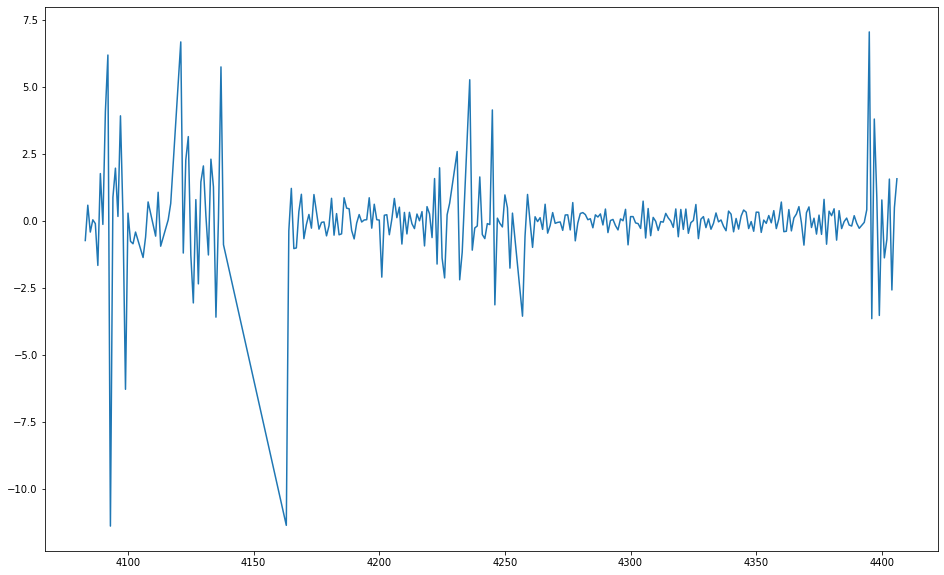

Trinity Biotech


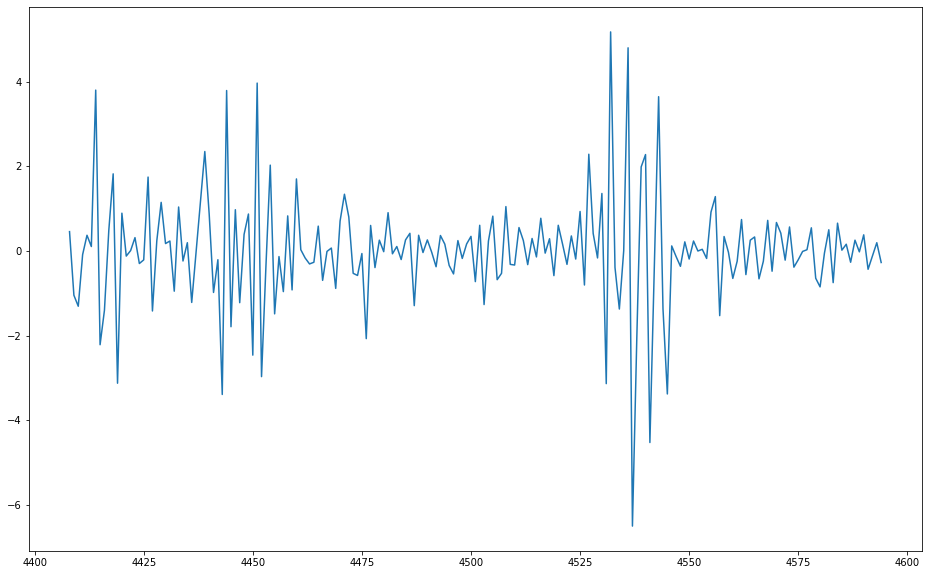

Vitros


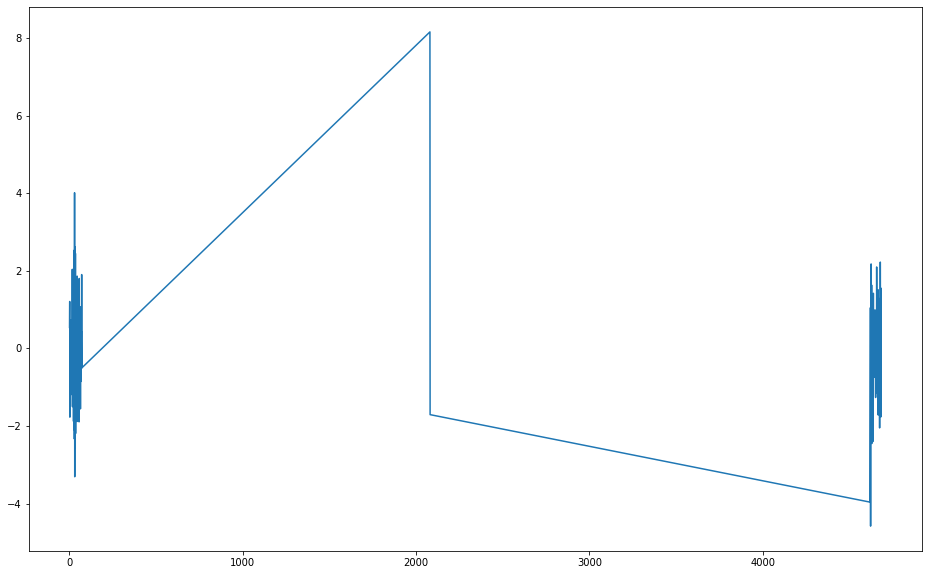

In [46]:
for name, data in manufacturers:
    print(name)
    data['Total'].diff().plot(figsize=(16,10))
    plt.show()

Abbott


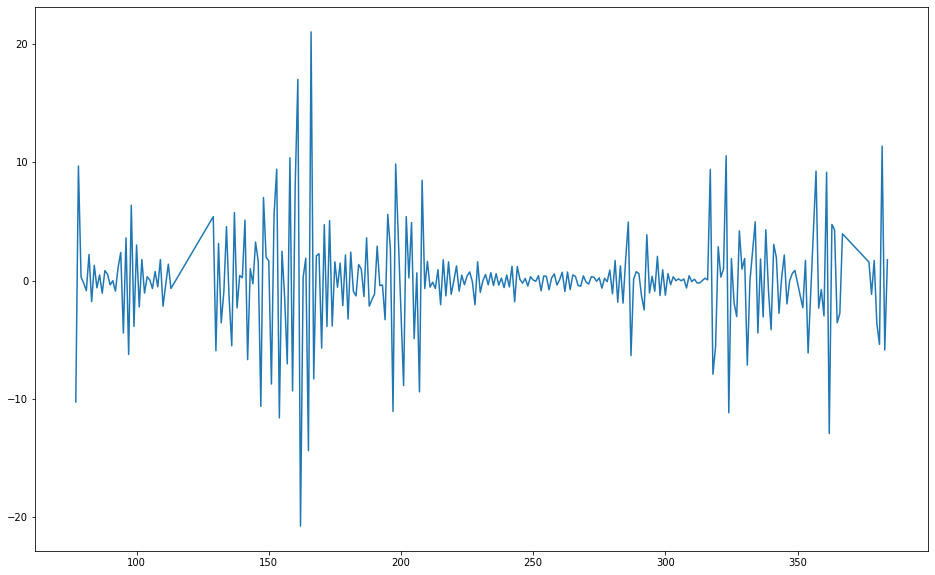

Alere


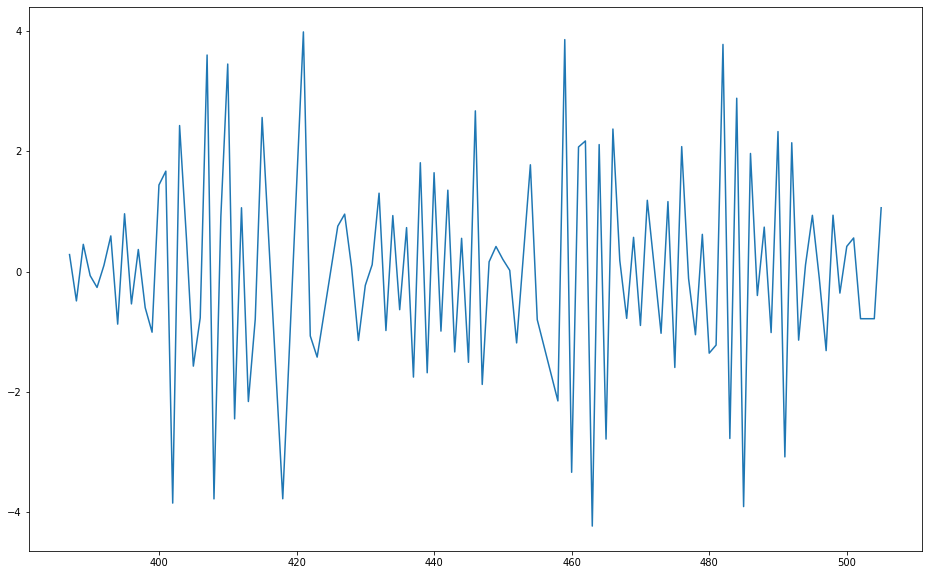

Beckman Coulter


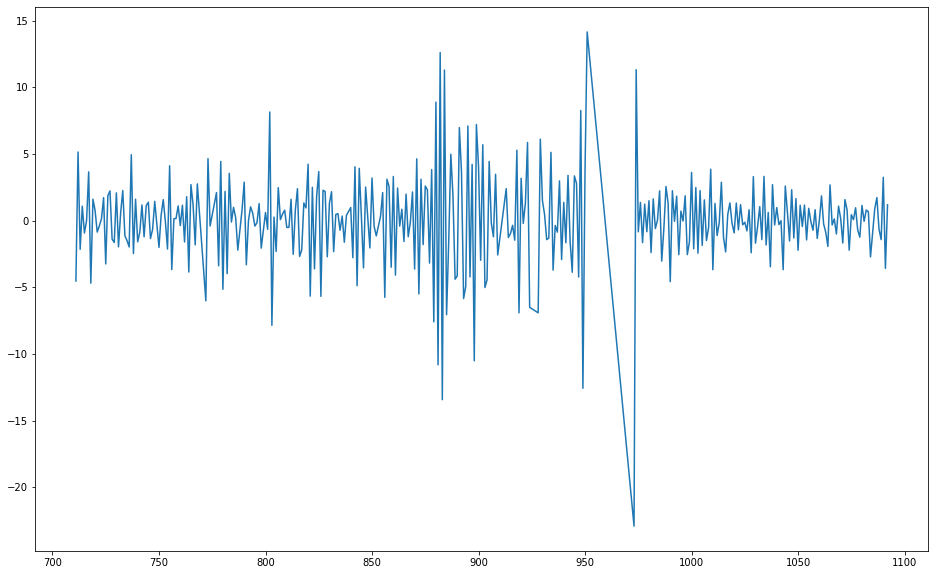

Bio-Rad


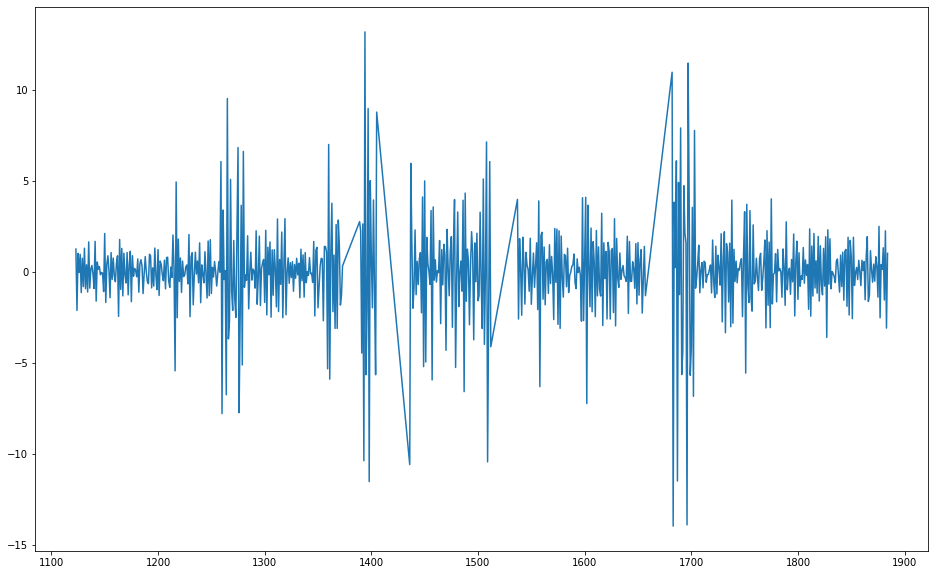

Roche Diagnostics


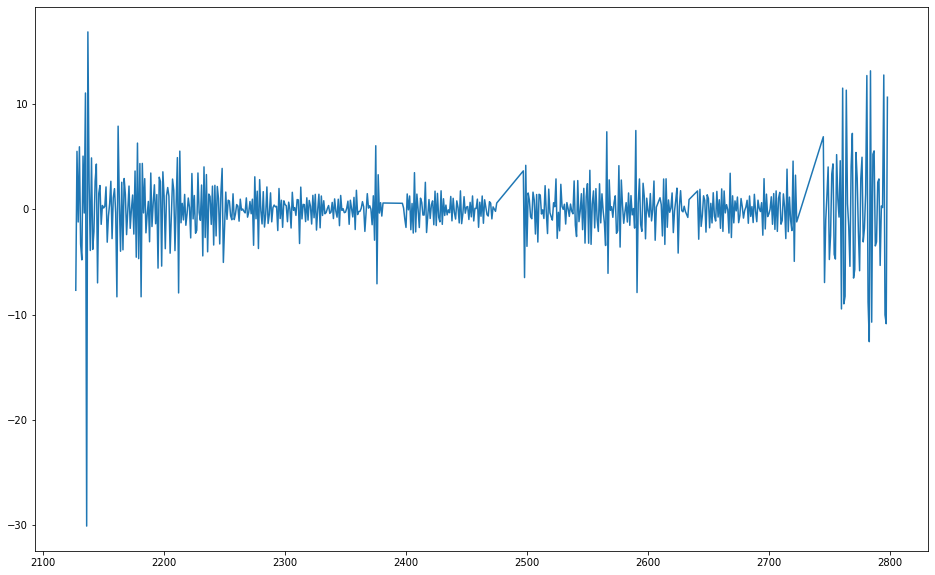

Sebia


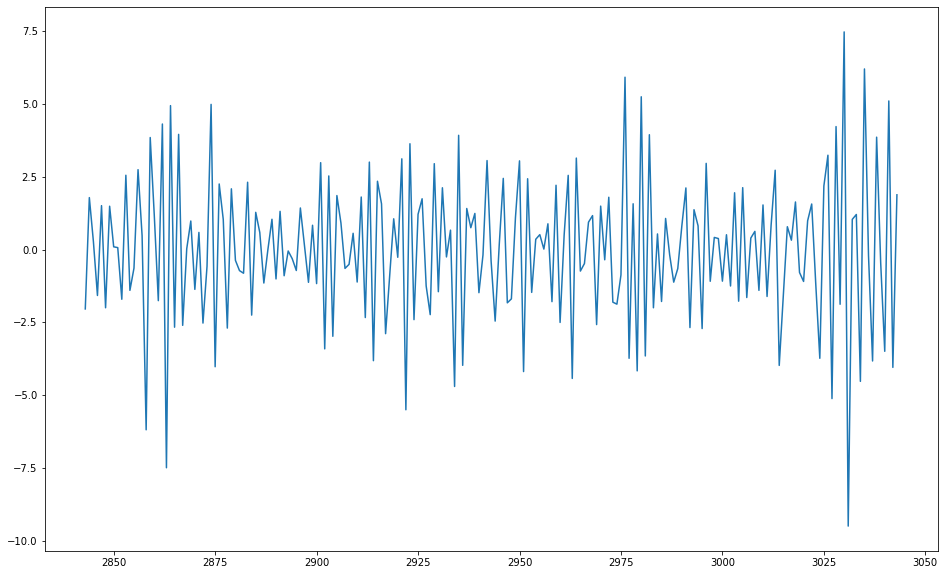

Siemens


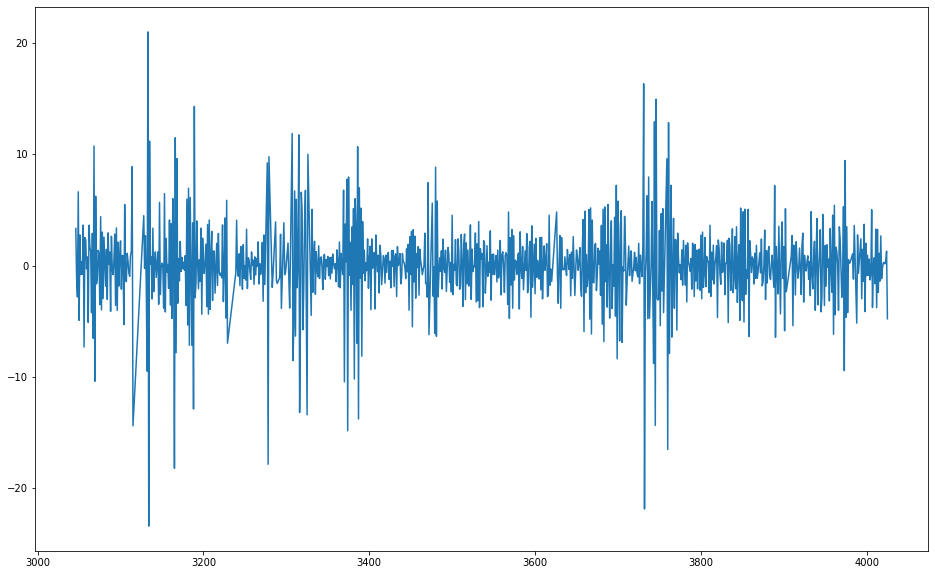

Tosoh


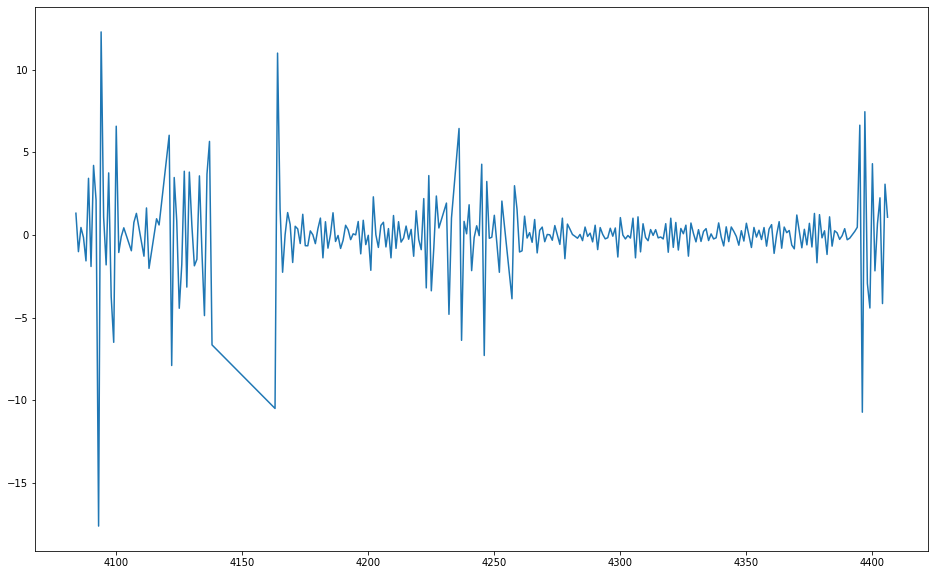

Trinity Biotech


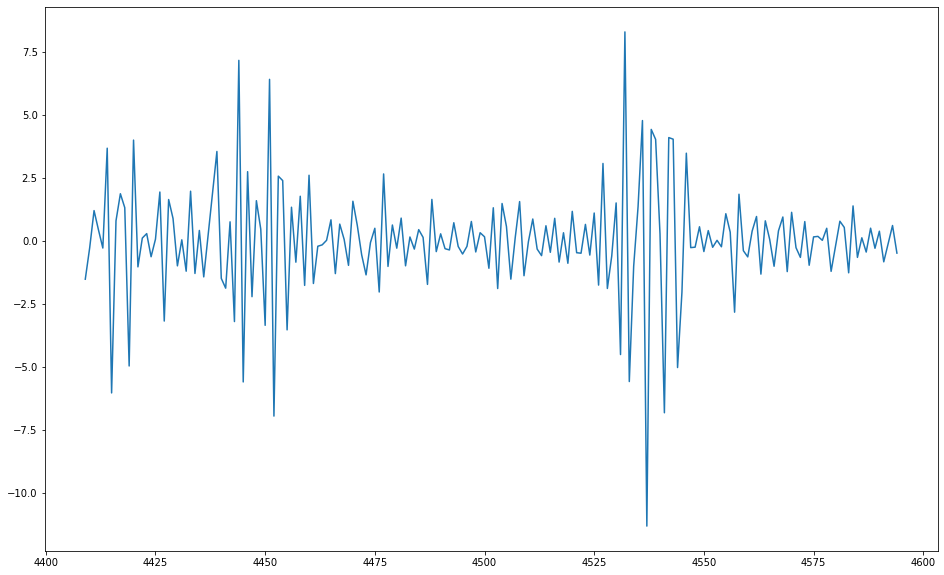

Vitros


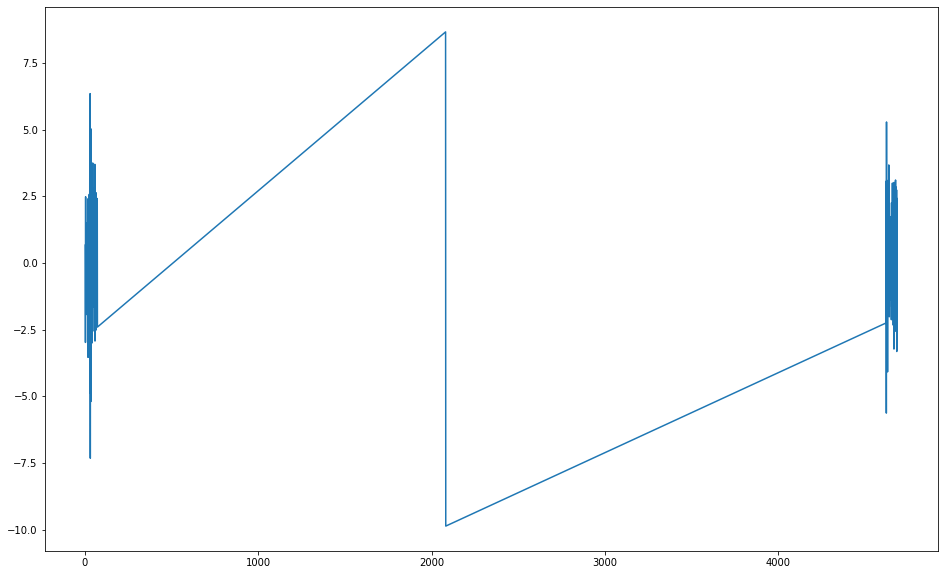

In [47]:

for name, data in manufacturers:
    print(name)
    data['Total'].diff().diff().plot(figsize=(16,10))
    plt.show()


#2x diff = I (ARIMA)


# Analyse autocorrelation plot
Hier is te zien dat bij de 2 keer differentiëren de data meer stationair lijkt. Daarom nemen we 2 als parameter. Dus ARIMA(p=?,d=2,q=?)

# Data preparation ACF & PACF

In [48]:
data['Total'] = data['Total'].diff().diff().dropna()

### ACF plot

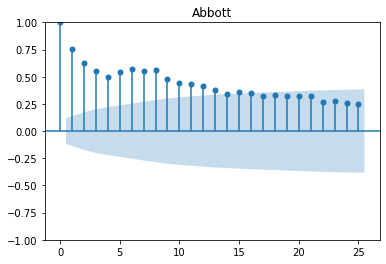

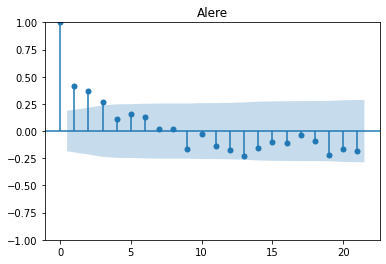

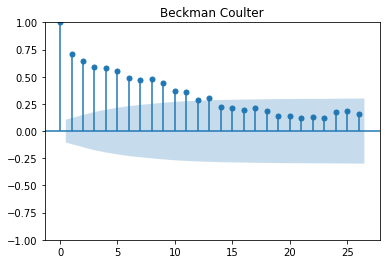

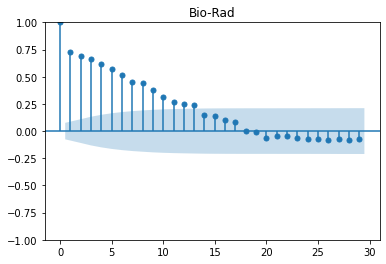

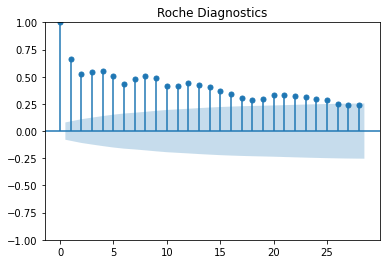

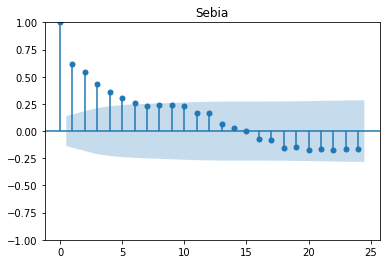

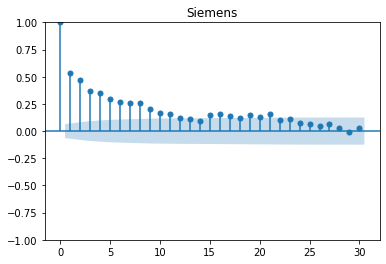

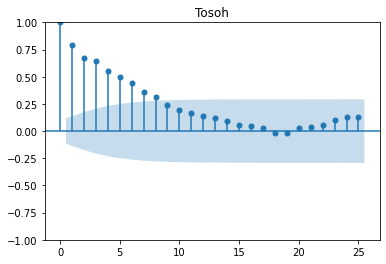

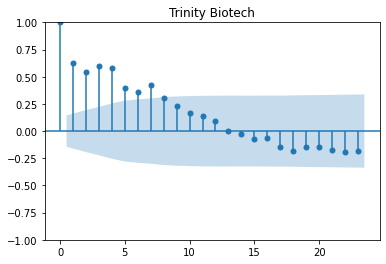

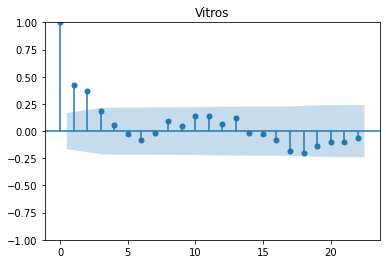

In [54]:
from statsmodels.graphics.tsaplots import plot_acf
for name, data in manufacturers: 
    acf =plot_acf(data['Total'], title=name)

### Analyse van ACF plot
In dit autocorrelatieplot liggen bijna alle waardes niet binnen het lichtblauwe onzekerheidsgebied (deze variantie in autocorrelatie kan worden verklaard door ruis). Dit betekent dat we wel MA-parameter hoeven in te stellen.

Voor de zekerheid bekijken we ook de autocorrelaties met een lag van twee weken.

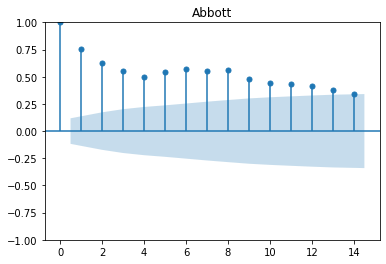

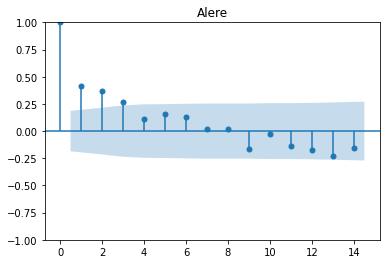

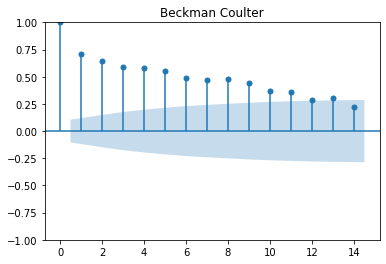

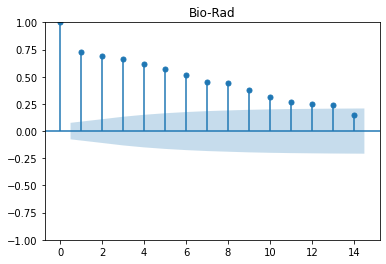

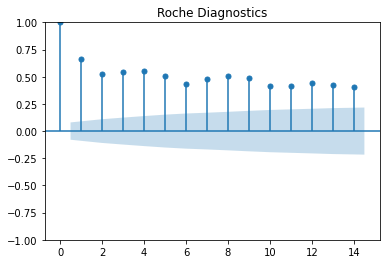

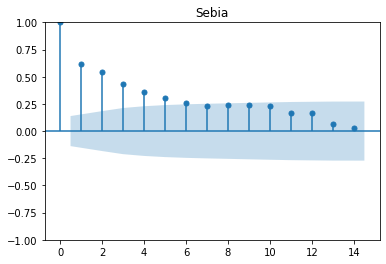

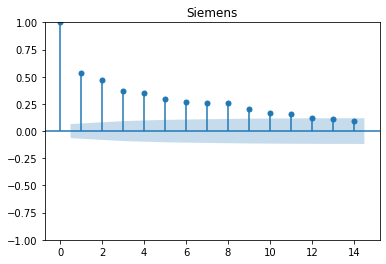

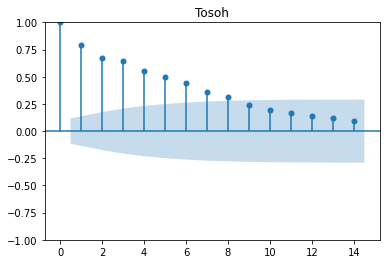

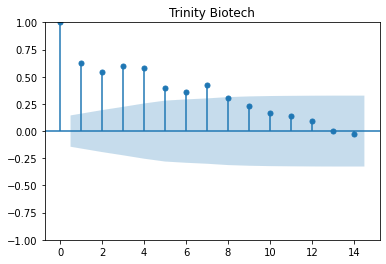

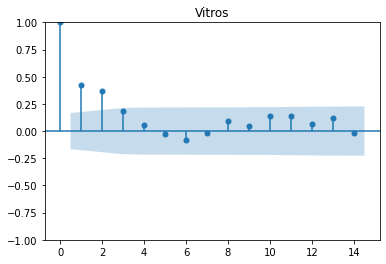

In [56]:
for name, data in manufacturers: 
    plot_acf(data['Total'], lags=14, title=name)

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

for name, data in manufacturers: 
    pacf = plot_pacf(data['Total'], title=name)

### Analyse van pacf plot
De partiële autocorrelatie geeft weer hoe sterk het verband is tussen de waarde van een lag en de waarde van voorgaande lags. Als er tussen de lags nog significante correlatie bestaat is dit een aanwijzing dat er auto-correlatie optreed en dat het instellen van de AR parameter een goed idee is.

Bij alle grafieken is te zien dat de eerste lag het meest significant is. Daarom nemen we p met de waarde 1. Dus ARIMA(p=1,d=2,q=?)

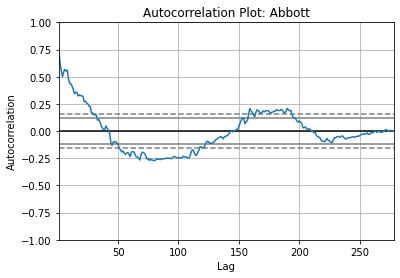

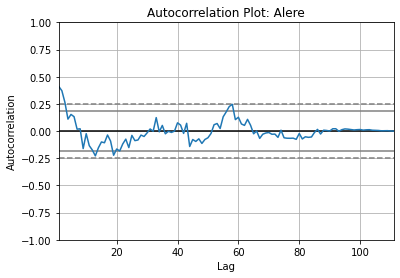

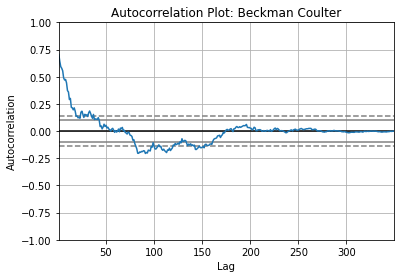

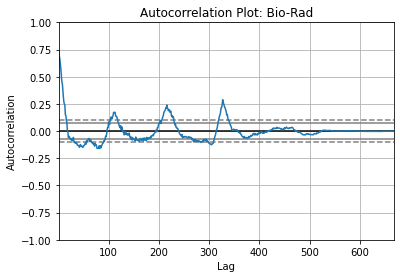

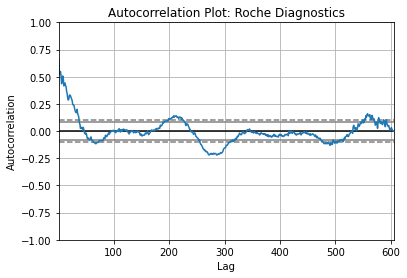

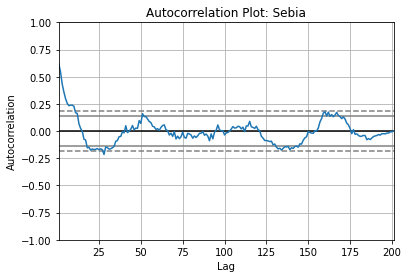

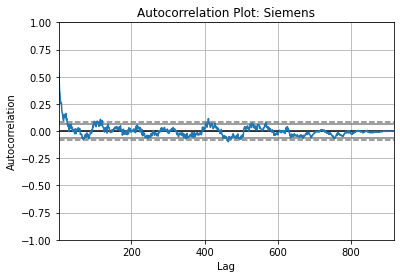

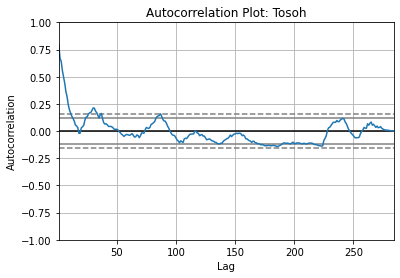

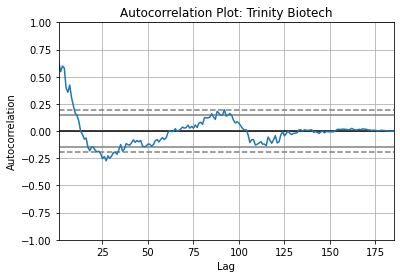

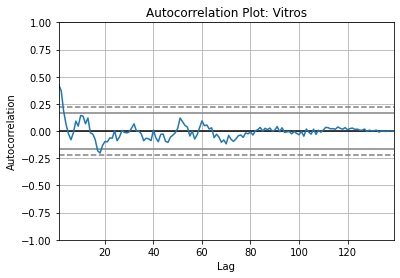

In [50]:
# from pandas.plotting import autocorrelation_plot
# for name, data in manufacturers: 
#     plt.title(f"Autocorrelation Plot: {name}")
#     autocorrelation_plot(data['Total'])
#     plt.show()

In [51]:
from statsmodels.tsa.ar_model import AutoReg
# Create training and test data
for name, data in manufacturers:
    train_data = data['Total'][:len(df)-100]
    test_data = data['Total'][len(df)-100:]
    #
    # Instantiate and fit the AR model with training data
    #
    ar_model = AutoReg(train_data, lags=1).fit()
    #
    # Print Summary
    #
    print(ar_model.summary())
    

                            AutoReg Model Results                             
Dep. Variable:                  Total   No. Observations:                  278
Model:                     AutoReg(1)   Log Likelihood                -654.749
Method:               Conditional MLE   S.D. of innovations              2.572
Date:                Mon, 23 May 2022   AIC                           1315.499
Time:                        06:01:05   BIC                           1326.371
Sample:                             1   HQIC                          1319.861
                                  278                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4144      0.277      5.106      0.000       0.872       1.957
Total.L1       0.7597      0.039     19.725      0.000       0.684       0.835
                                    Roots           

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: Val

In [52]:
# for name, data in manufacturers:
#     tempdf = df[['Year', 'Total']].dropna()

#     X = tempdf.iloc[:, :-1].values
#     Y = tempdf.iloc[:, 1].values

#     from sklearn.model_selection import train_test_split
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

#     from sklearn.linear_model import LinearRegression
#     regressor = LinearRegression()
#     regressor.fit(X_train, Y_train)

#     print(regressor.intercept_)
#     from matplotlib import pyplot

    
# for name, data in manufacturers:
#     # line plot for Total Error with seaborn
#     # if name == "Abbott":
#         # sns.set(rc = {'figure.figsize':(25,8)})
#         # l = sns.lineplot(x='Year', y='Total Error', data=data)
#         # sns.lineplot(x='Year', y={regressor.intercept_}, data=data)
#         # l.set_title(name)
#         # plt.show()
#         pyplot.plot('Year','Total Error',data=tempdf, color='red')
#         pyplot.plot('Year','Total Error', data=regressor.intercept_)

# Arima model

In [53]:
slotkoers_model = ARIMA(ARMA_data_slotkoers, order=(0,1,0))
slotkoers_model_fit = slotkoers_model.fit()
print(slotkoers_model_fit.summary())
fig = slotkoers_model_fit.plot_predict(n.adhead=3,dynamic=False)

#P>|z| significant? onder 0.01

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (1916551918.py, line 4)